# <center> Dota 2 winner prediction

<img src='https://habrastorage.org/webt/ua/vn/pq/uavnpqfoih4zwwznvxubu33ispy.jpeg'>

#### <center> Originally done by Peter Romov, translated and adapted by Yury Kashnitskiy (@yorko)
    
### Quick start

Grab features prepared by organizers, train a model and submit. 

1. [Data description](#Data-description)
2. [Features created by organizers](#Features-created-by-organizers)
3. [Training and evaluating a model](#Training-and-evaluating-a-model)
4. [Preparing a submission](#Preparing-a-submission)

### Now do it as a real Data Scientist

5. [Cross-validation](#Cross-validation)
6. [Working with all available information on Dota games](#Working-with-all-available-information-on-Dota-games)
7. [Feature engineering](#Feature-engineering)
8. [How to build initial features from scratch](#How-to-build-initial-features-from-scratch)

## Data description

We have the following files:

- `sample_submission.csv`: example of a submission file
- `train_matches.jsonl`, `test_matches.jsonl`: full "raw" training data 
- `train_features.csv`, `test_features.csv`: features created by organizers
- `train_targets.csv`: results of training games (including the winner)

## Features created by organizers

These are basic features which include simple players' statistics. Scroll to the end to see how to build these features from raw json files.

In [38]:
import os
import pandas as pd

PATH_TO_DATA = 'data/dota/'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

We have ~ 40k games, each described by `match_id_hash` (game id) and 245 features. Also `game_time` is given - time (in secs) when the game was over. 

In [39]:
df_train_features.shape

(39675, 245)

In [40]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.25,0,0,0,0


We are interested in the `radiant_win` column in `train_targets.csv`. All these features are not known during the game (they come "from future" as compared to `game_time`), so we have these features only for training data. 

In [41]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [42]:
df_train_features.shape, df_train_targets.shape

((39675, 245), (39675, 5))

In [43]:
df_train_features.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
count,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,...,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000
mean,1146.082798,19.584776,4.772350,6.524865,7.338500,51.103138,3.147876,3.268809,4.670170,6.289628,...,11.773324,1.039017,0.343138,4.683907,0.090132,0.415961,0.299811,0.024423,1.269288,0.783289
std,767.206621,6.304976,3.260582,6.492107,13.366381,34.603057,3.724282,3.283323,5.225349,8.203957,...,20.578321,3.534302,0.963734,4.643219,0.286375,0.267551,0.732490,0.170500,2.597549,2.437952
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-6.191284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.236842,0.000000,0.000000,0.000000,0.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,1.505127,0.000000,0.000000,3.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000
75%,1656.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,16.029575,0.000000,0.000000,7.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,84.000000,...,277.618070,132.000000,29.000000,57.000000,1.000000,2.000000,9.000000,5.000000,26.000000,47.000000


In [94]:
df_new = df_train_features[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', \
                           'r1_kills','r1_deaths','r1_gold','r1_towers_killed', 'r1_assists', 'r1_denies', 'r1_roshans_killed',\
                           'r2_kills','r2_deaths','r2_gold','r2_towers_killed', 'r2_assists', 'r2_denies', 'r2_roshans_killed',\
                           'r3_kills','r3_deaths','r3_gold','r3_towers_killed', 'r3_assists', 'r3_denies', 'r3_roshans_killed',\
                           'r4_kills','r4_deaths','r4_gold','r4_towers_killed', 'r4_assists', 'r4_denies', 'r4_roshans_killed',\
                           'r5_kills','r5_deaths','r5_gold','r5_towers_killed', 'r5_assists', 'r5_denies', 'r5_roshans_killed',\
                           'd1_kills','d1_deaths','d1_gold','d1_towers_killed', 'd1_assists', 'd1_denies', 'd1_roshans_killed',\
                           'd2_kills','d2_deaths','d2_gold','d2_towers_killed', 'd2_assists', 'd2_denies', 'd2_roshans_killed',\
                           'd3_kills','d3_deaths','d3_gold','d3_towers_killed', 'd3_assists', 'd3_denies', 'd3_roshans_killed',\
                           'd4_kills','d4_deaths','d4_gold','d4_towers_killed', 'd4_assists', 'd4_denies', 'd4_roshans_killed',\
                           'd5_kills','d5_deaths','d5_gold','d5_towers_killed', 'd5_assists', 'd5_denies', 'd5_roshans_killed'
                           ]]
df_train_full = df_new.merge(df_train_targets)
#df_train_full = df_train_features.merge(df_train_targets)

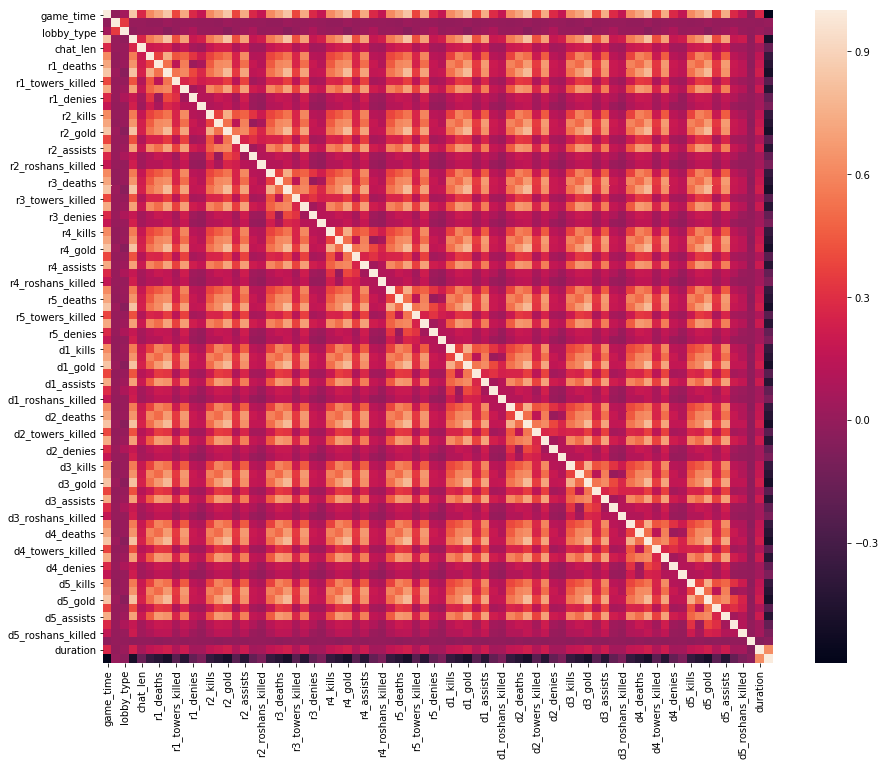

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
sns.heatmap(df_train_full.corr())

## Training and evaluating a model

#### Let's construct a feature matrix `X` and a target vector `y`

In [96]:
X = df_new.values
#X = df_train_features.values
y = df_train_targets['radiant_win'].values

#### Perform  a train/test split (a simple validation scheme)

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=17)

#### Train the Random Forest model

In [98]:
%%time
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model.fit(X_train, y_train)

Wall time: 2.45 s


#### Make predictions for the holdout set

We need to predict probabilities of class 1 - that Radiant wins, thus we need index 1 in the matrix returned by the `predict_proba` method.

In [99]:
y_pred = model.predict_proba(X_valid)[:, 1]

Let's take a look:

In [100]:
y_pred

array([0.07, 0.48, 0.54, ..., 0.5 , 0.45, 0.5 ])

#### Let's evaluate prediction quality with the holdout set

We'll calculate ROC-AUC.

In [101]:
from sklearn.metrics import roc_auc_score

valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7693080257670659


Out if curiosiry, we can calculate accuracy of a classifier which predicts class 1 if predicted probability is higher than 50%. 

In [102]:
from sklearn.metrics import accuracy_score

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', valid_accuracy)

Validation accuracy of P>0.5 classifier: 0.6928505418801982


## Preparing a submission

Now the same for test data.

In [103]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')

df_test = df_test_features[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',\
                           'r1_kills','r1_deaths','r1_gold','r1_towers_killed', 'r1_assists', 'r1_denies', 'r1_roshans_killed',\
                           'r2_kills','r2_deaths','r2_gold','r2_towers_killed', 'r2_assists', 'r2_denies', 'r2_roshans_killed',\
                           'r3_kills','r3_deaths','r3_gold','r3_towers_killed', 'r3_assists', 'r3_denies', 'r3_roshans_killed',\
                           'r4_kills','r4_deaths','r4_gold','r4_towers_killed', 'r4_assists', 'r4_denies', 'r4_roshans_killed',\
                           'r5_kills','r5_deaths','r5_gold','r5_towers_killed', 'r5_assists', 'r5_denies', 'r5_roshans_killed',\
                           'd1_kills','d1_deaths','d1_gold','d1_towers_killed', 'd1_assists', 'd1_denies', 'd1_roshans_killed',\
                           'd2_kills','d2_deaths','d2_gold','d2_towers_killed', 'd2_assists', 'd2_denies', 'd2_roshans_killed',\
                           'd3_kills','d3_deaths','d3_gold','d3_towers_killed', 'd3_assists', 'd3_denies', 'd3_roshans_killed',\
                           'd4_kills','d4_deaths','d4_gold','d4_towers_killed', 'd4_assists', 'd4_denies', 'd4_roshans_killed',\
                           'd5_kills','d5_deaths','d5_gold','d5_towers_killed', 'd5_assists', 'd5_denies', 'd5_roshans_killed'
                           ]]

X_test = df_test.values
#X_test = df_test_features.values
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)

In [104]:
df_submission.head()

,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.314025
70e5ba30f367cea48793b9003fab9d38,0.850000
4d9ef74d3a2025d79e9423105fd73d41,0.770000
2bb79e0c1eaac1608e5a09c8e0c6a555,0.620000
bec17f099b01d67edc82dfb5ce735a43,0.270000


Save the submission file, it's handy to include current datetime in the filename. 

In [105]:
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-03-25_16-32-42.csv


## Cross-validation

As we already know, cross-validation is a more reliable validation technique than just one train/test split. Here we'll resort to `ShuffleSplit` to create 5 70%/30% splits. 

In [106]:
from sklearn.model_selection import ShuffleSplit, KFold
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=17)

In [107]:
from sklearn.model_selection import cross_val_score

#### Run cross-validation

We'll train 2 versions of the  `RandomForestClassifier` model - first with default capacity (trees are not limited in depth), second - with `min_samples_leaf`=3, i.e. each leave is obliged to have at least 3 instances. 

In [108]:
%%time

model_rf1 = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                   max_depth=None, random_state=17)

# calcuate ROC-AUC for each split
cv_scores_rf1 = cross_val_score(model_rf1, X, y, cv=cv, scoring='roc_auc')

Wall time: 16 s


In [109]:
%%time

model_rf2 = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                   min_samples_leaf=3, random_state=17)

cv_scores_rf2 = cross_val_score(model_rf2, X, y, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)

Wall time: 14.2 s


#### CV results

The result returned by `cross_val_score` is an array with metric values (ROC-AUC) for each split:

In [110]:
cv_scores_rf1

array([0.76930803, 0.77377224, 0.77757132, 0.7732839 , 0.77111877])

In [111]:
cv_scores_rf2

array([0.77603772, 0.78043144, 0.78306034, 0.77950346, 0.77473299])

Let's compare average ROC-AUC among all splits for both models.

In [112]:
print('Model 1 mean score:', cv_scores_rf1.mean())
print('Model 2 mean score:', cv_scores_rf2.mean())

Model 1 mean score: 0.7730108504999328
Model 2 mean score: 0.7787531873160037


The second model is preferred. Look, there's a caveat here: the second model is actually better for 4 splits out of 5. So if we were to perform only one train/test split, there would've been a 20% probability to make a wrong conclusion that the first model is better.

In [113]:
cv_scores_rf2 > cv_scores_rf1

array([ True,  True,  True,  True,  True])

## Working with all available information on Dota games
Raw data descriptions for all games are given in files `train_matches.jsonl` and `test_matches.jsonl`. Each file has one entry for each game in [JSON](https://en.wikipedia.org/wiki/JSON) format. You only need to know that it can be easily converted to Python objects via the `json.loads` method.

##### Let's explore a single entry

In [114]:
import json

with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

The `match` object is now a big Python dictionary. In `match['players']` we have a description of each player.

You might think that this `match` object look ugly. You're right! That's actually the real data. And it's the ability to extract nice features from raw data that makes good Data Scientists stand out. You might even be unfamiliar with Dota (or any other application domain) but still be able to construct a good model via feature engineering. It's art and craftmanship at the same time.   

In [115]:
#match

#### Player description

In [116]:
player = match['players'][2]

KDA: the number of kills, deaths, and assists to alleys.

In [117]:
player['kills'], player['deaths'], player['assists']

(8, 11, 12)

Some statistics on player abilities:

In [118]:
player['ability_uses']

{'kunkka_torrent': 43,
 'kunkka_ghostship': 16,
 'kunkka_x_marks_the_spot': 8,
 'kunkka_return': 1}

#### Example: time series for each player's gold.

In [119]:
%matplotlib inline
from matplotlib import pyplot as plt

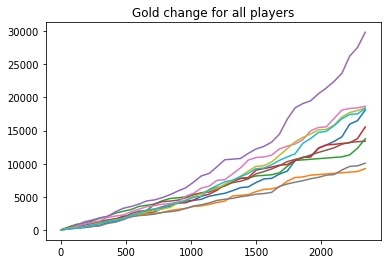

In [120]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players');

#### Function to read files with game descriptions

The following function `read_matches(filename)`, can be used to read raw data on Dota 2 games.

We recommend to install two Python packages: `ujson` and `tqdm`, it'll make the execution faster and 

In [121]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

Please install ujson to read JSON oblects faster


#### Reading data in a loop

Reading data on all games might take some 2-3 minutes. Thus you'd better stick to the following approach:

1. Read a small amount (10-100) of games
2. Write code to extract features from these JSON objects
3. Make sure the code works fine
4. Run the code with all available data
5. Save results to a `pickle` file so that you don't need to run all computations from scratch next time 

In [122]:
for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    # processing each game
    
    for player in match['players']:
        pass  # processing each player

## Feature engineering

In [123]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        
        # ... here you can add more features ...
        

In [124]:
# copy the dataframe with features
df_train_features_extended = df_new.copy()
#df_train_features_extended = df_train_features.copy()

# add new features
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              'train_matches.jsonl'))

We see new features added to the right.

In [125]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_kills,r1_deaths,r1_gold,r1_towers_killed,r1_assists,...,d5_kills,d5_deaths,d5_gold,d5_towers_killed,d5_assists,d5_denies,d5_roshans_killed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0,0,543,0,0,...,0,0,851,0,0,0,0,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,7,2,5257,0,0,...,0,2,1423,0,0,1,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0,0,176,0,0,...,0,0,96,0,0,0,0,0.0,0.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,1,0,1613,0,3,...,0,1,1333,0,0,1,0,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0,1,1404,0,1,...,0,1,2199,0,1,8,0,0.0,0.0,0.0


#### Evaluating new features

Let's run cross-validation with a fixed model but with two different datasets:

1. with features built by organizers (base)
2. with new features that we've added (extended)

In [126]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)

cv_scores_base = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_extended = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring='roc_auc', n_jobs=-1)

Wall time: 32.7 s


In [127]:
print('Base features: mean={} scores={}'.format(cv_scores_base.mean(), 
                                                cv_scores_base))
print('Extended features: mean={} scores={}'.format(cv_scores_extended.mean(), 
                                                    cv_scores_extended))

Base features: mean=0.7730112126671529 scores=[0.76930984 0.77377224 0.77757132 0.7732839  0.77111877]
Extended features: mean=0.7837948317934306 scores=[0.78422746 0.7862606  0.78475462 0.78128089 0.78245059]


In [128]:
cv_scores_extended > cv_scores_base

array([ True,  True,  True,  True,  True])

As we see, `RandomForestClassifier` shows better cross-validation results in case of the extended dataset. Looks reasonable, that's what we build features for.

#### New submission

In [129]:
%%time
# Build the same features for the test set
df_test_features_extended = df_test.copy()
#df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))


Wall time: 32.5 s


In [130]:
X.shape, len(y)

((39675, 75), 39675)

In [131]:
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model.fit(X, y)
df_submission_base = pd.DataFrame(
    {'radiant_win_prob': model.predict_proba(df_test.values)[:, 1]}, 
    #{'radiant_win_prob': model.predict_proba(df_test_features.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_base.to_csv('submission_base_rf.csv')

In [132]:
model_extended = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model_extended.fit(df_train_features_extended.values, y)
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': model_extended.predict_proba(df_test_features_extended.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_extended.to_csv('submission_extended_rf.csv')

In [133]:
****************

SyntaxError: invalid syntax (<ipython-input-133-b056cdf3f047>, line 1)

## How to build initial features from scratch

Now we diclose the code that we used to build initial features `train_features.csv` and `test_features.csv`. You can modify the following code to add more features.

In a nutshell:

1. the  `extract_features_csv(match)` function extracts features from game descriptions and writes them into a dictionary
2. the `extract_targets_csv(match, targets)` function extracts the target variable `radiant_win`
3. iterating through the file with raw data, we collect all features
4. with `pandas.DataFrame.from_records()` we create dataframes with new features

In [ ]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [ ]:
%%time

df_new_features = []
df_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
    

In [ ]:
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

In [ ]:
df_new_features.head()

## Go on!

- Discuss new ideas in Slack 
- Create new features
- Try new models and ensembles
- Submit predictions
- Go and win!